<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the data</a></span><ul class="toc-item"><li><span><a href="#Standardize-the-data" data-toc-modified-id="Standardize-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Standardize the data</a></span><ul class="toc-item"><li><span><a href="#Option-1" data-toc-modified-id="Option-1-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Option 1</a></span></li><li><span><a href="#Option-2" data-toc-modified-id="Option-2-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Option 2</a></span></li></ul></li></ul></li><li><span><a href="#Objective-function" data-toc-modified-id="Objective-function-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Objective function</a></span></li><li><span><a href="#Fitting-logistic-regression" data-toc-modified-id="Fitting-logistic-regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fitting logistic regression</a></span></li><li><span><a href="#Hyperparameter-optimization" data-toc-modified-id="Hyperparameter-optimization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hyperparameter optimization</a></span></li><li><span><a href="#Calibration" data-toc-modified-id="Calibration-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Calibration</a></span></li></ul></div>

# Regularized Logistic Regression
Solving the problem from homework 5 of the [foundations of machine learning course](https://bloomberg.github.io/foml/#home).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.spatial
import functools
from scipy.optimize import minimize
import pandas as pd
import seaborn as sns

%matplotlib inline

For a dataset $D = ((x_1,y_1),...,(x_n,y_n))$ drawn from $R^d \times \{-1,1\}$, the regularized logistic regression objective function can be defined as $$ J_{logistic}(w) = \hat{R_n}(w) + \lambda \|w\|^2$$  $$J_{logistic}(w) = \frac{1}{n} \sum_{i=1}^n log(1 + exp(-y_i w^T x_i)) +  \lambda \|w\|^2$$  

Is $ J_{logistic}(w) $ convex?  

- $-y_i w^T x_i$ is an affine function of $w$
- $exp(\cdot)$ is a convex function
- The composition of a convex function with an affine function is convex so $exp(-y_i w^T x_i)$ is convex  


- Log-Sum-Exp: $(x_1,..., x_n) \to log (e^{x_1} + ... + e^{x_n})$ is convex on $R^n$ so $log(1 + exp(-y_i w^T x_i))$ is convex on $R^n$
- Non-negative weighted sums of convex functions is convex so $\frac{1}{n} \sum_{i=1}^n log(1 + exp(-y_i w^T x_i))$ is convex
- Every norm on $R^n$ is convex therefore $\|w\|^2$ is convex. $\lambda > 0$ so $\lambda \|w\|^2$ is convex

## Load the data

In [2]:
def load_data(file):
    with open(file, 'r') as f:
        lines = []   
        for line in f.readlines():
            lines.append([float(x) for x in line.strip().split(',')])
       
    return np.asarray(lines)

In [3]:
X_train = load_data('X_train.txt')
X_val = load_data('X_val.txt')
y_train = load_data('y_train.txt')
y_val = load_data('y_val.txt')

In [4]:
#transform the classes from {0,1} to {-1,1}

y_train = y_train.reshape(-1)
y_train[y_train == 0]=-1

y_val = y_val.reshape(-1)
y_val[y_val == 0]=-1

### Standardize the data

#### Option 1

In [5]:
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size (num_instances, num_features)
        test  - test set, a 2D numpy array of size (num_instances, num_features)
    Returns:
        train_normalized - training set after normalization with added bias
        test_normalized  - test set after normalization with added bias

    """
    train_normalized = (train - train.min(axis=0))/(train.max(axis=0)-train.min(axis=0))
    test_normalized = (test - train.min(axis=0))/(train.max(axis=0)-train.min(axis=0))
    
    n1,d1 = train.shape
    n2,d2 = test.shape
    
    X1 = np.ones((n1,1))
    Xtrain_new = np.hstack((X1,train_normalized))
    
    X2 = np.ones((n2,1))
    Xtest_new = np.hstack((X2,test_normalized))
    
    return (Xtrain_new, Xtest_new)

In [6]:
X_train_normalized, X_val_normalized = feature_normalization(X_train, X_val)

#### Option 2

In [7]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_val_minmax = min_max_scaler.transform(X_val)

#Add bias term
X_train_minmax_bias = np.hstack((np.ones((X_train_minmax.shape[0],1)),X_train_minmax))
X_val_minmax_bias = np.hstack((np.ones((X_val_minmax.shape[0],1)),X_val_minmax))

## Objective function

In [8]:
def f_objective(theta, X, y, l2_param=1):
    '''
    Args:
        theta: 1D numpy array of size num_features
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
        l2_param: regularization parameter

    Returns:
        objective: scalar value of objective function
    '''
    n,d = X.shape
    
    y = y.reshape(-1) #if we are given a column vector
   
    max_array = np.zeros(n)
    
    score = -y*(X@theta)
    max_array2 = np.maximum(max_array,score)
    
    empirical_risk = (1/n) * np.sum((max_array2+np.logaddexp(0-max_array2,score-max_array2)))
    
    total_cost = empirical_risk + l2_param*theta.T@theta
    
    return total_cost

## Fitting logistic regression

In [9]:
def fit_logistic_reg(X, y, l2_param=1):
    '''
    Args:
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
        objective_function: function returning the value of the objective
        l2_param: regularization parameter
        
    Returns:
        optimal_theta: 1D numpy array of size num_features
    '''
    
    n,d = X.shape
    theta0 = np.zeros(d)
    
    y = y.reshape(-1) #if we are given a column vector
    
    def f_obj(theta):
        max_array = np.zeros(n)
    
        score = -y*(X@theta)
        max_array2 = np.maximum(max_array,score)
    
        empirical_risk = (1/n) * np.sum((max_array2+np.logaddexp(0-max_array2,score-max_array2)))
    
        total_cost = empirical_risk + l2_param*theta.T@theta
    
        return total_cost

    mini = minimize(f_obj, theta0, options={'gtol': 1e-6, 'disp': True})
    optimal_theta=mini.x
    print(mini.message)
    
    return optimal_theta

In [10]:
optimal_theta = fit_logistic_reg(X_train_normalized, y_train, l2_param=0.001)
optimal_theta

Optimization terminated successfully.
         Current function value: 0.579487
         Iterations: 50
         Function evaluations: 1144
         Gradient evaluations: 52
Optimization terminated successfully.


array([-0.02023094,  0.05382901,  0.00464291,  0.65168235,  4.26120568,
       -0.19470411, -0.09043079, -0.13652105, -0.1487172 , -0.24573054,
       -2.1959969 ,  0.37614467, -0.0798709 , -0.07168626, -0.05689424,
       -0.06982594,  0.02549784, -0.07006439, -0.4310903 , -0.25766318,
       -0.51010758])

## Hyperparameter optimization

In [11]:
LL_list = []
l2_param_list = [1.0e-7, 1e-6, 1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1]
for l2_param in l2_param_list:
    optimal_theta = fit_logistic_reg(X_train_normalized, y_train, l2_param=l2_param)
    LL_list.append(f_objective(optimal_theta, X_val_normalized, y_val, l2_param=l2_param))
    
LL = {'l2_param': l2_param_list, 'Negative log-likelihood': LL_list}

Optimization terminated successfully.
         Current function value: 0.545428
         Iterations: 70
         Function evaluations: 1584
         Gradient evaluations: 72
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.545473
         Iterations: 70
         Function evaluations: 1584
         Gradient evaluations: 72
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.545918
         Iterations: 70
         Function evaluations: 1584
         Gradient evaluations: 72
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.550154
         Iterations: 69
         Function evaluations: 1562
         Gradient evaluations: 71
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.579487
         Iterations: 50
         Function evaluations: 1144
         Gra

In [12]:
df = pd.DataFrame(LL)
print(df)

min_idx = df['Negative log-likelihood'].idxmin()

print('\n')
print('The regression parameter that minimized NLL on the validation set was {:.2e}.'.format(df['l2_param'][min_idx]))

       l2_param  Negative log-likelihood
0  1.000000e-07                 0.587031
1  1.000000e-06                 0.587055
2  1.000000e-05                 0.587289
3  1.000000e-04                 0.589581
4  1.000000e-03                 0.607781
5  1.000000e-02                 0.659551
6  1.000000e-01                 0.688060
7  1.000000e+00                 0.692599


The regression parameter that minimized NLL on the validation set was 1.00e-07.


Text(0, 0.5, 'Negative-Log-likelihood')

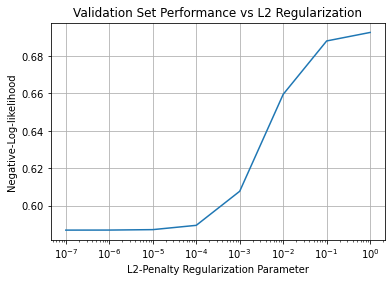

In [13]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots()

ax.semilogx(df["l2_param"], df["Negative log-likelihood"])
ax.grid()
ax.set_title("Validation Set Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Negative-Log-likelihood")

## Calibration
  
We can interpret the prediction $f(x) = \Phi (w^Tx) = 1/(1+e^{-w^T x})$ as the probability that $y = 1$, for a randomly drawn pair $(x,y)$.  
Since we only have a finite sample (and we are regularizing, which will bias things a bit) there is a question of how well “calibrated” our predicted probabilities are.  
Roughly speaking, we say $f(x)$ is well calibrated if we look at all examples $(x,y)$ for which $f(x) = 0.7$ and we find that close to 70 % of those examples have $y = 1$, as predicted... and then we repeat that for all predicted probabilities in $(0, 1)$.

In [14]:
def sigmoid(theta, xi):
    score = np.dot(theta.T,xi)
    sig = 1/(1+np.exp(-score))
    return sig

In [15]:
optimal_theta = fit_logistic_reg(X_train_normalized, y_train, l2_param=0.00001)
pred=[]
for i in range(len(X_val_normalized)):
    pred.append(sigmoid(optimal_theta,X_val_normalized[i,:]))
    
calibration = {'Prediction': pred, 'True class': y_val}

df_calib = pd.DataFrame(calibration)
df_calib

Optimization terminated successfully.
         Current function value: 0.545918
         Iterations: 70
         Function evaluations: 1584
         Gradient evaluations: 72
Optimization terminated successfully.


,Prediction,True class
0,0.319346,-1.0
1,0.740077,1.0
2,0.221699,-1.0
3,0.114294,1.0
4,0.795415,-1.0
...,...,...
395,0.791300,1.0
396,0.229150,-1.0
397,0.330077,-1.0
398,0.463779,1.0


In [22]:
#Revert back to 0-1 classes, easier for summing 
df_calib['True class 0-1'] = 1 
df_calib.loc[df_calib['True class']== -1, 'True class 0-1'] = 0

#Divide the predictions into groups of same values
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
cats = pd.cut(df_calib['Prediction'], bins, right=True)
grouped = df_calib['True class 0-1'].groupby(cats)

#Function returning the count of elements in each group and the sum of errors
def get_stats(group):
    return {'count': group.count(), 'sum': group.sum()}

df2 = grouped.apply(get_stats).unstack()

#Calculate the fraction of predictions for y=1
df2['fraction of positives'] = (df2['sum']/df2['count'])

#Add column for plotting
df2['Categories'] = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
df2

,count,sum,fraction of positives,Categories
Prediction,,,,
"(0.0, 0.1]",7,2,0.285714,0.1
"(0.1, 0.2]",40,12,0.300000,0.2
"(0.2, 0.3]",60,15,0.250000,0.3
"(0.3, 0.4]",63,14,0.222222,0.4
"(0.4, 0.5]",50,20,0.400000,0.5
"(0.5, 0.6]",37,19,0.513514,0.6
"(0.6, 0.7]",33,28,0.848485,0.7
"(0.7, 0.8]",35,31,0.885714,0.8
"(0.8, 0.9]",40,32,0.800000,0.9


Text(0.5, 1.0, 'Calibration plots (reliability curve)')

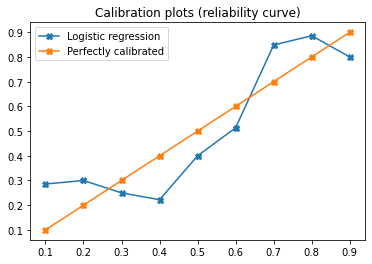

In [24]:
fig, ax = plt.subplots()
ax.plot(df2["Categories"], df2["fraction of positives"], label='Logistic regression', marker='X')
ax.plot(df2["Categories"], df2["Categories"], label='Perfectly calibrated', marker='X')

ax.legend(loc='best')
ax.set_title('Calibration plots (reliability curve)')